In [1]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset

In [2]:
class CernDatasetFullEvo(Dataset):
    def __init__(self, folder, evo_length=9, max_dataset_size=None, load_from_npy=False, load_velocities=False, modified_velocities=True):
        self.root_dir = folder
        self.evo_length = evo_length
        self.load_from_npy = load_from_npy
        self.load_velocities = load_velocities
        self.modified_velocities = modified_velocities
        self.paths = []

        broken_files = {
            'D:/CernDataset/447/jobresult_5/printing_VISHNew/results/snapshot_Ed.dat',
            'D:/CernDataset/802/jobresult_8/printing_VISHNew/results/snapshot_Ed.dat',
            'D:/CernDataset/985/jobresult_1/printing_VISHNew/results/snapshot_Ed.dat'
        }

        for idx in os.listdir(folder):
            for jobresult in os.listdir(f'{folder}/{idx}'):
                path = f'{folder}/{idx}/{jobresult}/printing_VISHNew/results/snapshot_Ed.dat'
                if path not in broken_files:
                    self.paths.append(f'{idx}/{jobresult}')

        if load_velocities:
            paths_t = []
            for path in self.paths:
                path_t = f'{folder}/{path}/printing_VISHNew/results'
                if (os.path.exists(f'{path_t}/vx.npy') and
                    os.path.exists(f'{path_t}/vy.npy') and
                    os.path.getsize(f'{path_t}/vx.npy') == 2452484 and 
                    os.path.getsize(f'{path_t}/vy.npy') == 2452484):
                    paths_t.append(path)
            self.paths = paths_t

        if max_dataset_size is not None:
            self.paths = self.paths[:max_dataset_size]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        sample_name = self.paths[index]
        sample_path = os.path.join(self.root_dir, sample_name)

        img = np.array([], dtype=np.float32)
        y = np.array([], dtype=np.float32)

        if self.load_from_npy:
            y = np.load(f'{sample_path}/printing_VISHNew/results/y.npy')
            img = np.load(f'{sample_path}/printing_VISHNew/results/img.npy')
        else:
            with open(f'{sample_path}/printing_VISHNew/results/snapshot_Ed.dat') as f:
                for idx, line in enumerate(f):
                    if idx > 262 and idx < 262 * 2:
                        t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float32)
                        img = np.hstack((img, t))
                    if idx > 262 * 2 and idx < 262 * (self.evo_length + 2) and (idx % 262 != 0):
                        t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float32)
                        y = np.hstack((y, t))

        if self.load_velocities:
            vxs = np.load(f'{sample_path}/printing_VISHNew/results/vx.npy')
            vys = np.load(f'{sample_path}/printing_VISHNew/results/vy.npy')
            y = np.concatenate((y, vxs))
            y = np.concatenate((y, vys))

        y_t = torch.from_numpy(y.reshape((-1, 261, 261)))
        img_t = torch.from_numpy(img.reshape((1, 261, 261)))

        if self.modified_velocities:
            y_t[9:18] *= y_t[:9]
            y_t[18:27] *= y_t[:9]
        y_t = y_t[:, 3:-2, 3:-2]
        img_t = img_t[:, 3:-2, 3:-2]

        return img_t, y_t

    
class OxygenDataset(Dataset):
    def __init__(self, folder, max_dataset_size=None, modified_velocities=True):
        self.root_dir = folder
        self.modified_velocities = modified_velocities
        self.paths = []

        for idx in os.listdir(folder):
            for jobresult in os.listdir(f'{folder}/{idx}'):
                path = f'{folder}/{idx}/{jobresult}/printing_VISHNew/results/snapshot_Ed.dat'
                self.paths.append(f'{idx}/{jobresult}')

        if max_dataset_size is not None:
            self.paths = self.paths[:max_dataset_size]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        sample_name = self.paths[index]
        sample_path = os.path.join(self.root_dir, sample_name)

        Ed = np.load(f'{sample_path}/printing_VISHNew/results/Ed.npy')
        Vx = np.load(f'{sample_path}/printing_VISHNew/results/Vx.npy')
        Vy = np.load(f'{sample_path}/printing_VISHNew/results/Vy.npy')
            
        ev = np.concatenate((Ed, Vx))
        ev = np.concatenate((ev, Vy))

        ev = torch.from_numpy(ev.reshape((-1, 261, 261)))
        ev_length = ev.size(dim=0) // 3 
        #x = torch.stack((ev[0], ev[ev_length], ev[2 * ev_length]))
        x = torch.unsqueeze(ev[0], dim=0)
        y = torch.cat((ev[1:ev_length], ev[ev_length + 1:2*ev_length], ev[2*ev_length+1: ]))
        
        if self.modified_velocities:
            y[ev_length-1:2*ev_length-2] *= y[:ev_length-1]
            y[2*ev_length-2:] *= y[:ev_length-1]
        y = y[:, 3:-2, 3:-2]
        x = x[:, 3:-2, 3:-2]

        return x, y
    
    def generate_npys(self):
        """Generates img.npy and y.npy for each training sample for faster load."""
        num_paths = len(self.paths)
        for i, path in enumerate(self.paths):
            sample_path = os.path.join(self.root_dir, path)

            Ed = np.array([], dtype=np.float32)
            Vx = np.array([], dtype=np.float32)
            Vy = np.array([], dtype=np.float32)

            with open(f'{sample_path}/printing_VISHNew/results/snapshot_Ed.dat') as f:
                for idx, line in enumerate(f):
                    if idx % 262 == 0 or idx < 262:
                        continue
                    t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float32)
                    Ed = np.hstack((Ed, t))
            with open(f'{sample_path}/printing_VISHNew/results/snapshot_Vx.dat') as f:
                for idx, line in enumerate(f):
                    if idx % 262 == 0 or idx < 262:
                        continue
                    t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float32)
                    Vx = np.hstack((Vx, t))
            with open(f'{sample_path}/printing_VISHNew/results/snapshot_Vy.dat') as f:
                for idx, line in enumerate(f):
                    if idx % 262 == 0 or idx < 262:
                        continue
                    t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float32)
                    Vy = np.hstack((Vy, t))

            np.save(f'{sample_path}/printing_VISHNew/results/Ed.npy',  Ed)
            np.save(f'{sample_path}/printing_VISHNew/results/Vx.npy',  Vx)
            np.save(f'{sample_path}/printing_VISHNew/results/Vy.npy',  Vy)

            print(f'{i+1}/{num_paths} generated')


In [3]:
def plot_ev(evolution, t_freeze=0.18, eps=0.01):
    Ed, Vx, Vy = evolution
    ev_length = Ed.shape[0]
    fig = plt.figure(figsize=(ev_length*3,9))
    for i in range(len(Ed)):
        fig.add_subplot(3, len(Ed), i + 1)
        plt.imshow(Ed[i], alpha=0.9)
        plt.imshow(np.abs(Ed[i]- t_freeze) < eps, alpha=0.1)
        fig.add_subplot(3, len(Ed), i + len(Ed) + 1)
        plt.imshow(Vx[i], alpha=0.9)
        fig.add_subplot(3, len(Ed), i + 2 * len(Ed) + 1)
        plt.imshow(Vy[i], alpha=0.9)

In [4]:
path_to_models = 'models'

def predict(x, threshold=0.005):
    Ed = np.array((x))
    Vx = np.array((np.zeros_like(x)))
    Vy = np.array((np.zeros_like(x)))
    x = torch.from_numpy(x)
    x = torch.unsqueeze(torch.unsqueeze(x, 0), 0).to(device)

    for t in range(9):
        model = torch.load(f'{path_to_models}/u{t}{t+1}.pth')
        model.eval()

        x = model(x) 
        prediction = x.detach().cpu().numpy()

        Ed = np.append(Ed, prediction[0, 0])
        Vx = np.append(Vx, prediction[0, 1])
        Vy = np.append(Vy, prediction[0, 2])

    return Ed.reshape((-1, 256, 256)), Vx.reshape((-1, 256, 256)), Vy.reshape((-1, 256, 256))

def predict_until_freeze(x, t_freeze=0.18):
    Ed = np.array((x))
    Vx = np.array((np.zeros_like(x)))
    Vy = np.array((np.zeros_like(x)))
    x = torch.from_numpy(x)
    x = torch.unsqueeze(torch.unsqueeze(x, 0), 0).to(device)

    for t in range(9):
        model = torch.load(f'{path_to_models}/u{t}{t+1}.pth')
        model.eval()

        x = model(x) 
        prediction = x.detach().cpu().numpy()
        if np.max(prediction[0, 0]) < t_freeze:
            break

        Ed = np.append(Ed, prediction[0, 0])
        Vx = np.append(Vx, prediction[0, 1])
        Vy = np.append(Vy, prediction[0, 2])

    return Ed.reshape((-1, 256, 256)), Vx.reshape((-1, 256, 256)), Vy.reshape((-1, 256, 256))

In [5]:
def rectify(ev):
    return torch.from_numpy(np.asarray(ev)[:, 1:, :, :].reshape(-1, 256, 256))

def unet_loss(output, target):
    loss = 0.5 * torch.sum(torch.abs(output - target)) / torch.sum(torch.abs(target))
    return loss

def loss(x, y, id=-1):
    loss = 0
    if len(x) != len(y):
        print(f'id={id} predicted ev_length differs, len_pred={len(x)}, len_y={len(y)}')
        return 0
    for i in range(len(y)):
        loss += unet_loss(x[i], y[i])
    return loss

In [6]:
def plot_y(y):
    plt.figure(figsize=(9*3, 3*3))
    for i in range(9):
        plt.subplot(3, 9, i + 1)
        plt.imshow(y[i])
        plt.grid(False)
        plt.axis('off')
        plt.subplot(3, 9, i + 10)
        plt.imshow(y[i + 9])
        plt.grid(False)
        plt.axis('off')
        plt.subplot(3, 9, i + 19)
        plt.imshow(y[i + 18])
        plt.grid(False)
        plt.axis('off')

In [7]:
def calc_summ_error(index):
    x, y = dataset[index]
    ev = predict(torch.squeeze(x).numpy())
    return loss(rectify(ev), y)

def calc_summ_error_until_freeze(index, dataset):
    x, y = dataset[index]
    ev = predict_until_freeze(torch.squeeze(x).numpy())
    return loss(rectify(ev), y, index)

In [3]:
train_folder = 'D:/OOMinBias'

In [4]:
dataset_oxygen = OxygenDataset(train_folder)
x, y = dataset_oxygen[3]

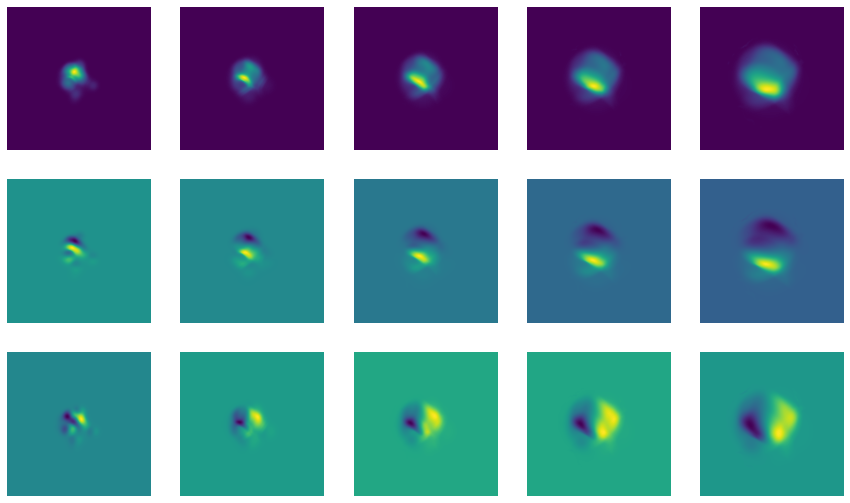

In [5]:
# dataset = CernDatasetFullEvo(train_folder, load_from_npy=False, 
#                                      load_velocities=False,
#                                      modified_velocities=False)
# print(len(dataset))
# x, y = dataset[3]
ev_l = (y.shape[0] // 3)
plt.figure(figsize=(ev_l*3, 3*3))
for i in range(ev_l):
    plt.subplot(3, ev_l, i + 1)
    plt.imshow(y[i])
    plt.grid(False)
    plt.axis('off')
    plt.subplot(3, ev_l, i + ev_l + 1)
    plt.imshow(y[i + ev_l])
    plt.grid(False)
    plt.axis('off')
    plt.subplot(3, ev_l, i + 2 * ev_l + 1)
    plt.imshow(y[i + 2 * ev_l])
    plt.grid(False)
    plt.axis('off')

In [111]:
%%time
ev = predict(torch.squeeze(x).numpy())

KeyboardInterrupt: 

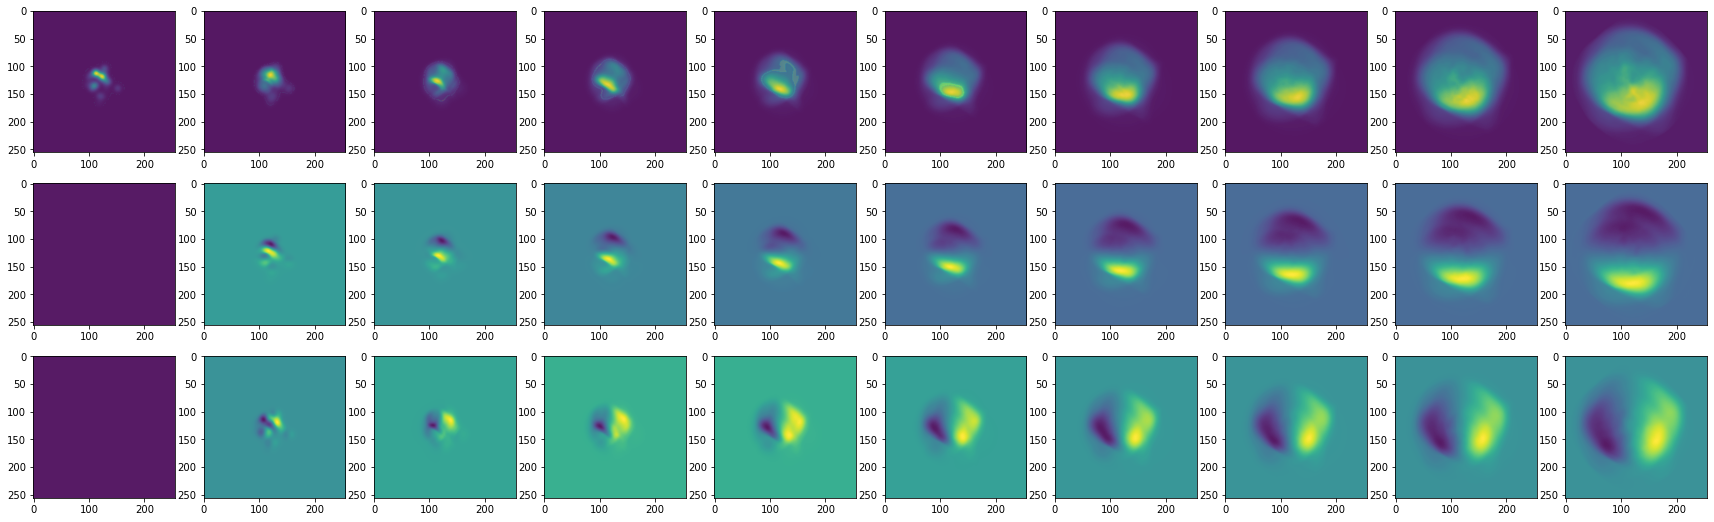

In [30]:
plot_ev(ev)

In [10]:
prediction = torch.from_numpy(np.asarray(ev)[:, 1:, :, :].reshape(27, 256, 256))

In [27]:
loss(prediction[8], y[8])

tensor(92.2807)

In [13]:
loss(prediction, y)

tensor(0.1367)

# Посмотрим на суммарную потерю на других входных данных

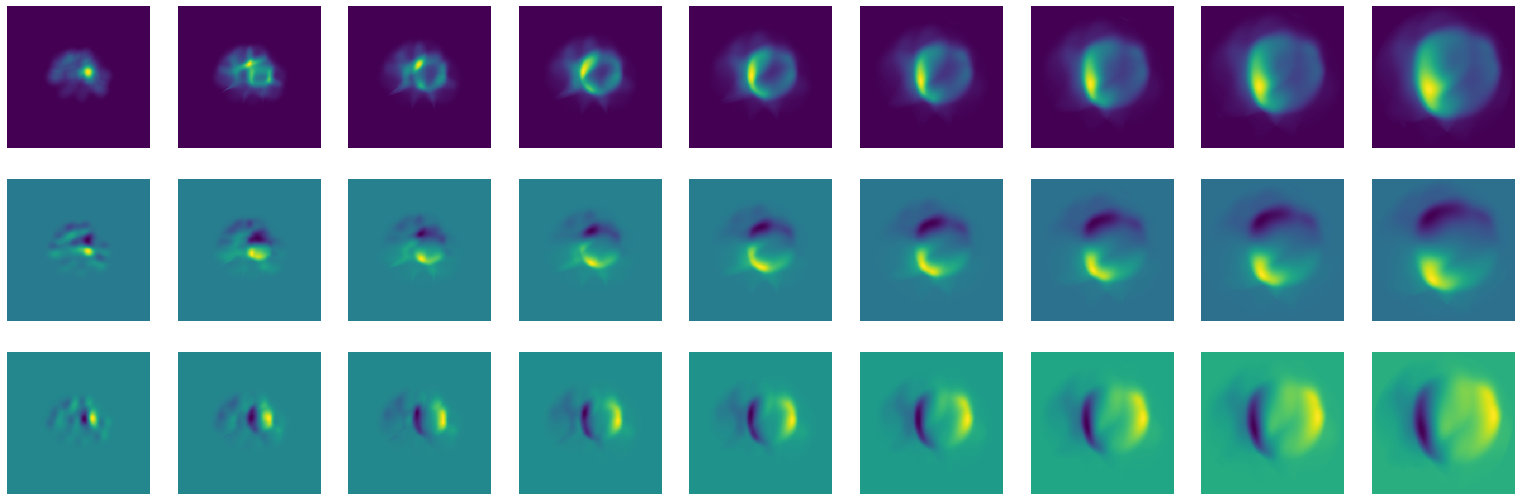

In [18]:
x, y = dataset[13]
plot_y(y)

In [29]:
x = torch.zeros_like(x)
x[100:-100, 100:-100] = 0.5

In [30]:
ev = predict(torch.squeeze(x).numpy())

TypeError: squeeze(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [20]:
loss(rectify(ev), y)

tensor(0.1053)

In [22]:
calc_summ_error(17)

tensor(0.1086)

In [23]:
calc_summ_error(173)

tensor(0.0806)

# Действительно ли новые модели лучше?

In [24]:
path_to_models = 'D:/models'

In [25]:
calc_summ_error(17)

tensor(0.4507)

In [26]:
calc_summ_error(173)

tensor(0.3996)

# Предсказания для кислорода

In [25]:
x,y = dataset_oxygen[3]

In [26]:
%%time
ev = predict_until_freeze(torch.squeeze(x).numpy())

Wall time: 4.31 s


In [27]:
ev[0].shape

(6, 256, 256)

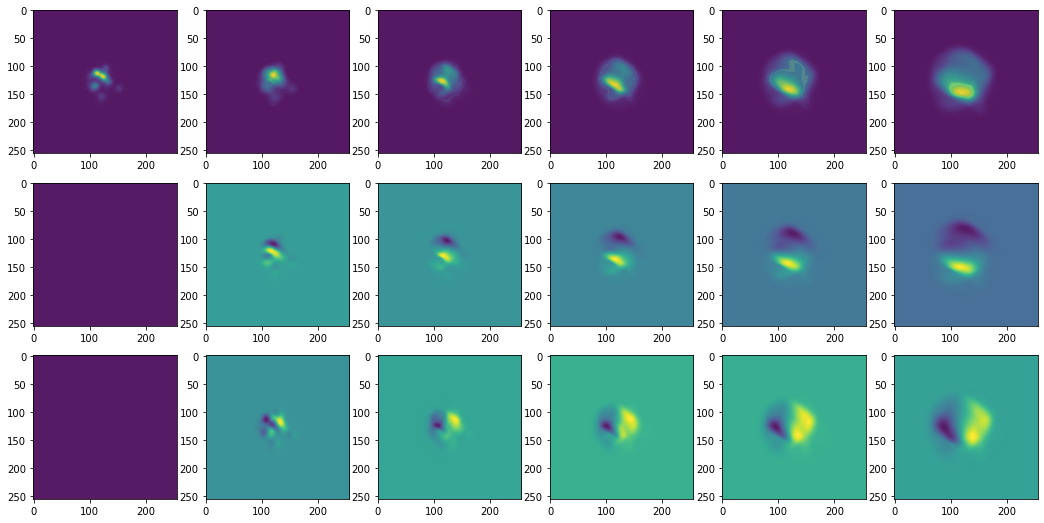

In [28]:
plot_ev(ev)

In [29]:
loss(rectify(ev), y)

tensor(0.0775)

In [35]:
calc_summ_error_until_freeze(3, dataset_oxygen)

tensor(0.0775)

Посчитаем среднюю суммарную ошибку

In [42]:
s = 0
n = 0
ids_misc = []
for i in range(len(dataset_oxygen)):
    er = calc_summ_error_until_freeze(i, dataset_oxygen)
    if er == 0:
        ids_misc.append(i)
        continue
    s += er
    n += 1
print(s / n)

id=5 predicted ev_length differs
id=11 predicted ev_length differs
id=14 predicted ev_length differs
id=16 predicted ev_length differs
id=17 predicted ev_length differs
id=23 predicted ev_length differs
id=28 predicted ev_length differs
id=34 predicted ev_length differs
id=35 predicted ev_length differs
id=41 predicted ev_length differs
id=47 predicted ev_length differs
id=51 predicted ev_length differs
id=55 predicted ev_length differs
id=62 predicted ev_length differs
id=73 predicted ev_length differs
id=115 predicted ev_length differs
id=127 predicted ev_length differs
id=150 predicted ev_length differs
id=163 predicted ev_length differs
id=169 predicted ev_length differs
id=188 predicted ev_length differs
id=198 predicted ev_length differs
id=199 predicted ev_length differs
id=215 predicted ev_length differs
id=227 predicted ev_length differs
id=237 predicted ev_length differs
id=248 predicted ev_length differs
id=256 predicted ev_length differs
id=265 predicted ev_length differs
i

In [43]:
len(ids_misc)

147

In [60]:
calc_summ_error_until_freeze(14, dataset_oxygen)

id=14 predicted ev_length differs, len_pred=12, len_y=6


0

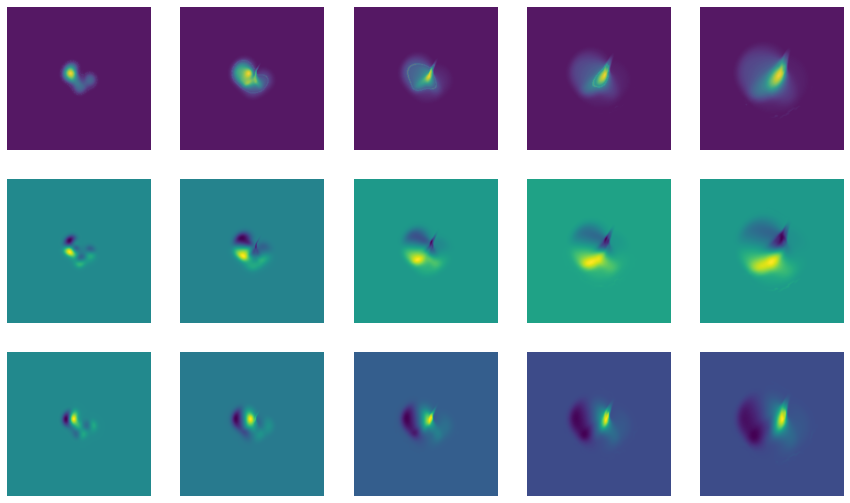

In [69]:
eps = 0.01
x, y = dataset_oxygen[11]
ev_l = (y.shape[0] // 3)
plt.figure(figsize=((ev_l + 1)*3, 3*3))
plt.subplot(3, ev_l, i + 1)
for i in range(ev_l):
    plt.subplot(3, ev_l, i + 2)
    plt.imshow(y[i], alpha=0.9)
    plt.imshow(np.abs(y[i]- 0.18) < eps, alpha=0.1)
    plt.grid(False)
    plt.axis('off')
    plt.subplot(3, ev_l, i + ev_l + 2)
    plt.imshow(y[i + ev_l])
    plt.grid(False)
    plt.axis('off')
    plt.subplot(3, ev_l, i + 2 * ev_l + 2)
    plt.imshow(y[i + 2 * ev_l])
    plt.grid(False)
    plt.axis('off')
plt.savefig('actual.png')

In [70]:
ev = predict_until_freeze(torch.squeeze(x).numpy())

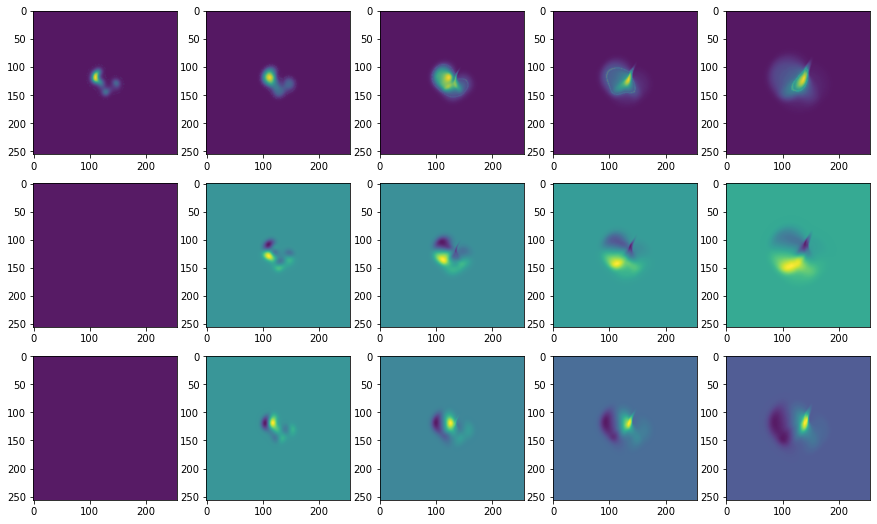

In [71]:
plot_ev(ev)

# Посчитаем ошибку на исходном датасете

In [47]:
train_folder = 'D:/CernDataset'

In [48]:
dataset = CernDatasetFullEvo(train_folder, load_from_npy=True, 
                             load_velocities=True,
                             modified_velocities=True)

In [49]:
data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

In [51]:
len(val_indices)

1641

In [72]:
s = 0
n = 0
for i in range(1000):
    er = calc_summ_error(i)
    if er == 0:
        ids_misc.append(i)
        continue
    s += er
    n += 1
    if i % 100 == 0:
        print(s/ n)
print(s / n)

tensor(0.0968)
tensor(0.0971)
tensor(0.0974)
tensor(0.0975)
tensor(0.0964)
tensor(0.0965)
tensor(0.0964)
tensor(0.0964)
tensor(0.0961)
tensor(0.0959)
tensor(0.0958)


# Предсказания для свинца

In [6]:
train_folder = 'D:/PbPbMinBias'

In [7]:
dataset_pb = OxygenDataset(train_folder)

In [63]:
x, y = dataset_pb[1]

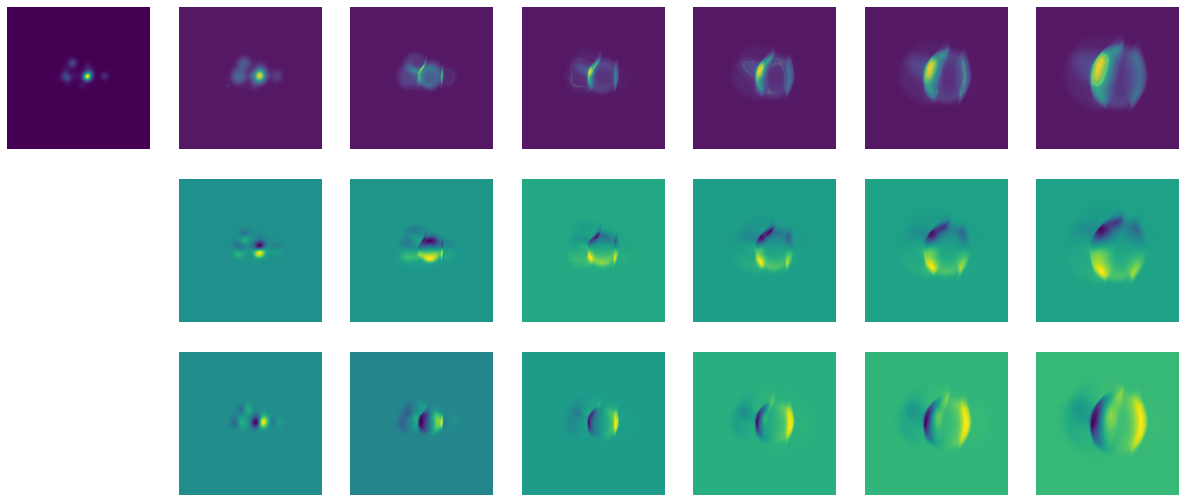

In [64]:
eps=0.01
ev_l = (y.shape[0] // 3)
plt.figure(figsize=((ev_l+1)*3, 3*3))
plt.subplot(3, ev_l+1, 1)
plt.imshow(x[0])
plt.grid(False)
plt.axis('off')
for i in range(ev_l):
    plt.subplot(3, ev_l+1, i + 2)
    plt.imshow(y[i], alpha=0.9)
    plt.imshow(np.abs(y[i]- 0.18) < eps, alpha=0.1)
    plt.grid(False)
    plt.axis('off')
    plt.subplot(3, ev_l+1, i + ev_l + 3)
    plt.imshow(y[i + ev_l])
    plt.grid(False)
    plt.axis('off')
    plt.subplot(3, ev_l+1, i + 2 * ev_l + 4)
    plt.imshow(y[i + 2 * ev_l])
    plt.grid(False)
    plt.axis('off')

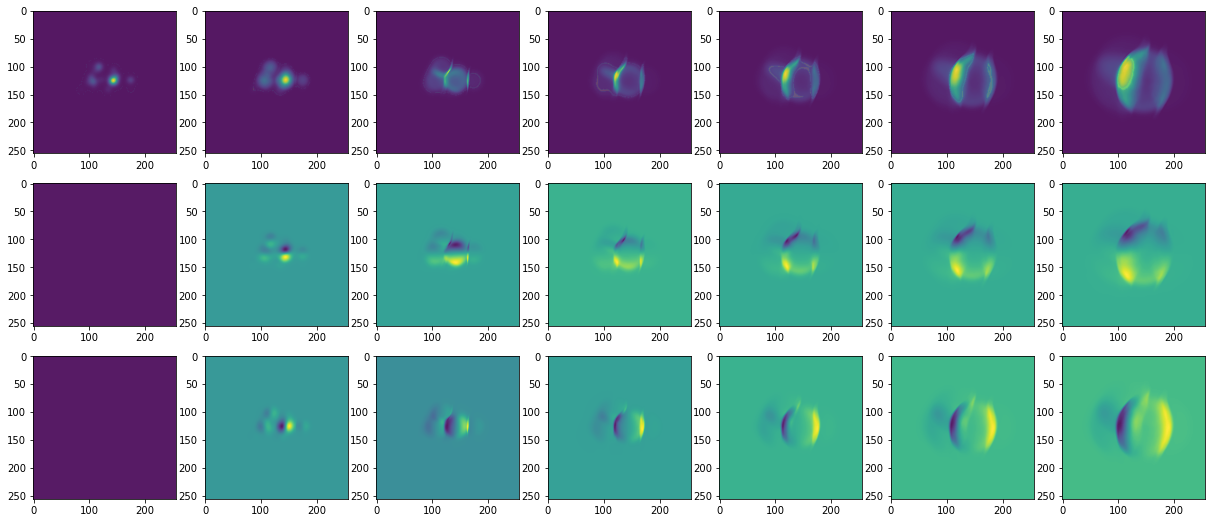

In [65]:
ev = predict_until_freeze(torch.squeeze(x).numpy())
plot_ev(ev)

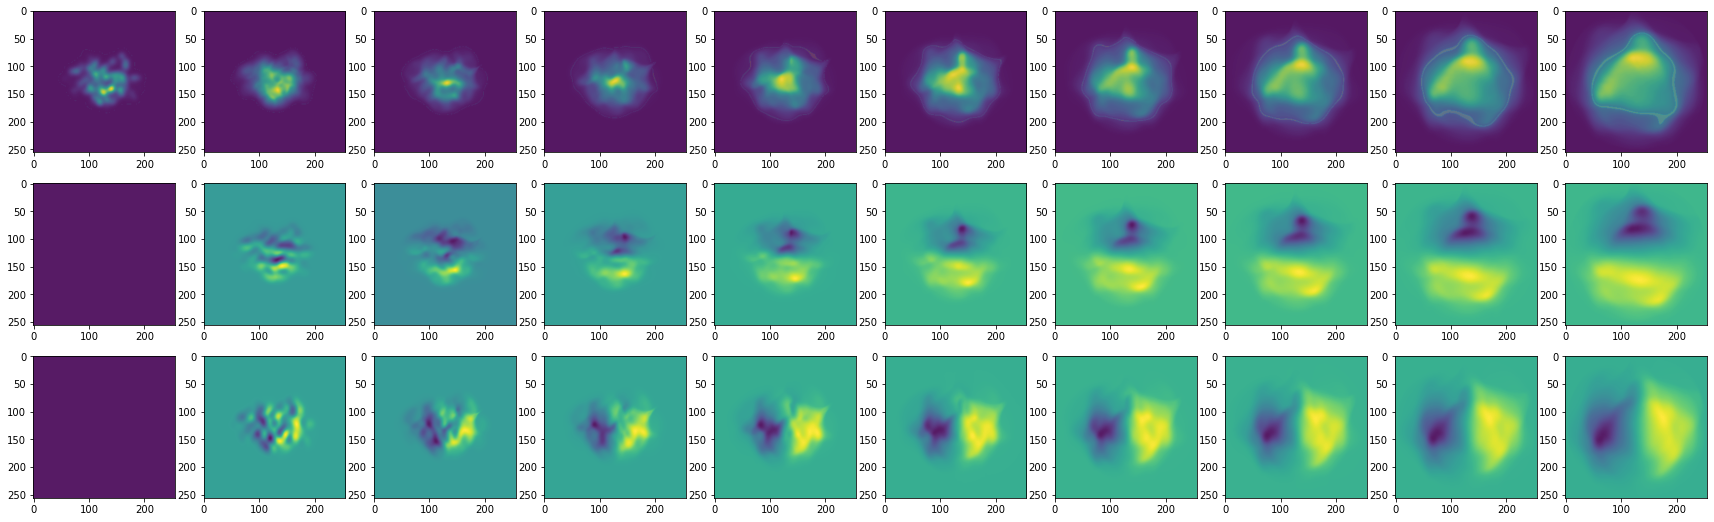

In [41]:
x, y = dataset_pb[30]
ev = predict_until_freeze(torch.squeeze(x).numpy())
plot_ev(ev)

In [51]:
wrong_evols = []

def loss_pb(x, y, id=-1):
    loss = 0
    if len(x) != len(y):
        wrong_evols.append((id, len(x), len(y)))
    x_l = len(x) // 3
    y_l = len(y) // 3
    for i in range(min(x_l, y_l)):
        loss += unet_loss(x[i], y[i])
        loss += unet_loss(x[i+x_l], y[i+y_l])
        loss += unet_loss(x[i+2 * x_l], y[i+2*y_l])
        
    return loss, min(len(x), len(y))

In [55]:
loss_pb(rectify(ev), y)

(tensor(0.0941), 27)

In [46]:
def calc_summ_error_until_freeze_pb(index, dataset):
    x, y = dataset[index]
    ev = predict_until_freeze(torch.squeeze(x).numpy())
    return loss_pb(rectify(ev), y, index)

In [67]:
from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(1000):
    er, l = calc_summ_error_until_freeze_pb(i, dataset_pb)
    sum_error[l] += er
    num_evols[l] += 1
    
# Ошибка произошла потому, что в датасете оказалось 998 семплов, а не 1000.

IndexError: list index out of range

In [69]:
sum_error

defaultdict(float,
            {24: tensor(9.9058),
             18: tensor(12.0879),
             27: tensor(67.2111),
             21: tensor(9.9455),
             3: tensor(0.0244),
             15: tensor(10.3918),
             12: tensor(6.5304),
             9: tensor(1.9746),
             6: tensor(0.6155)})

In [73]:
num_evols

defaultdict(int,
            {24: 97,
             18: 108,
             27: 467,
             21: 97,
             3: 1,
             15: 98,
             12: 75,
             9: 37,
             6: 18})

In [74]:
wrong_evols

[(2, 27, 42),
 (6, 27, 33),
 (7, 27, 33),
 (8, 27, 36),
 (10, 27, 30),
 (11, 27, 30),
 (14, 27, 42),
 (17, 27, 30),
 (18, 24, 27),
 (19, 27, 30),
 (21, 15, 18),
 (23, 27, 30),
 (26, 12, 15),
 (27, 27, 30),
 (28, 27, 39),
 (29, 27, 36),
 (30, 27, 33),
 (32, 27, 39),
 (33, 27, 30),
 (36, 27, 42),
 (43, 27, 45),
 (44, 15, 18),
 (45, 18, 21),
 (46, 27, 39),
 (47, 27, 36),
 (48, 27, 42),
 (53, 24, 27),
 (55, 27, 36),
 (56, 27, 39),
 (59, 27, 39),
 (60, 27, 30),
 (61, 27, 42),
 (64, 21, 24),
 (65, 18, 21),
 (68, 27, 42),
 (69, 27, 30),
 (72, 27, 39),
 (75, 27, 36),
 (78, 27, 36),
 (83, 27, 36),
 (84, 27, 33),
 (86, 27, 33),
 (88, 27, 36),
 (92, 24, 27),
 (93, 27, 42),
 (97, 27, 39),
 (100, 27, 30),
 (102, 27, 33),
 (103, 27, 30),
 (108, 15, 18),
 (111, 27, 30),
 (116, 27, 42),
 (118, 27, 39),
 (121, 27, 30),
 (126, 27, 30),
 (127, 27, 36),
 (129, 27, 33),
 (130, 27, 42),
 (131, 21, 24),
 (132, 27, 45),
 (133, 27, 42),
 (137, 27, 30),
 (138, 27, 36),
 (139, 27, 36),
 (140, 27, 36),
 (145, 27,

# Предсказания для Xe

In [12]:
train_folder = 'D:/XeXeMinBias'

In [13]:
dataset_xe = OxygenDataset(train_folder)

In [14]:
x, y = dataset_xe[4]
plot_y(y)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/XeXeMinBias\\001/jobresult_4/printing_VISHNew/results/Ed.npy'

# Оценим модель, принимающую 4 входа

In [10]:
def predict_until_freeze_single_model(x, t_freeze=0.18, mod='ucp'):
    Ed = np.array((x))
    Vx = np.array((np.zeros_like(x)))
    Vy = np.array((np.zeros_like(x)))
    
    t = np.zeros_like(x)
    if mod == 'ucp_wtt':
        x = torch.from_numpy(np.array((x, np.zeros_like(x), np.zeros_like(x))))
    else:
        x = torch.from_numpy(np.array((x, np.zeros_like(x), np.zeros_like(x), t)))
    x = torch.unsqueeze(x, 0).to(device)
    model = torch.load(f'{path_to_models}/{mod}.pth')
    model.eval()
    for i in range(9):
        x = model(x) 
        prediction = x.detach().cpu().numpy() 
        if np.max(prediction[0, 0]) < t_freeze:
            break

        Ed = np.append(Ed, prediction[0, 0])
        Vx = np.append(Vx, prediction[0, 1])
        Vy = np.append(Vy, prediction[0, 2])
                                  
        t += 1
        if mod != 'ucp_wtt':
            prediction = np.concatenate((prediction, np.expand_dims(t, axis=(0,1))),axis=1)
        x = torch.from_numpy(prediction).to(device) 

    return Ed.reshape((-1, 256, 256)), Vx.reshape((-1, 256, 256)), Vy.reshape((-1, 256, 256))

In [11]:
path_to_models = 'C:/Users/Юра/Desktop/CernProject/models'

## pbMinBias

In [8]:
train_folder = 'D:/PbPbMinBias'
dataset_pb = OxygenDataset(train_folder)

In [77]:
x, y = dataset_pb[2]

In [42]:
ev = predict_until_freeze_single_model(torch.squeeze(x).numpy())

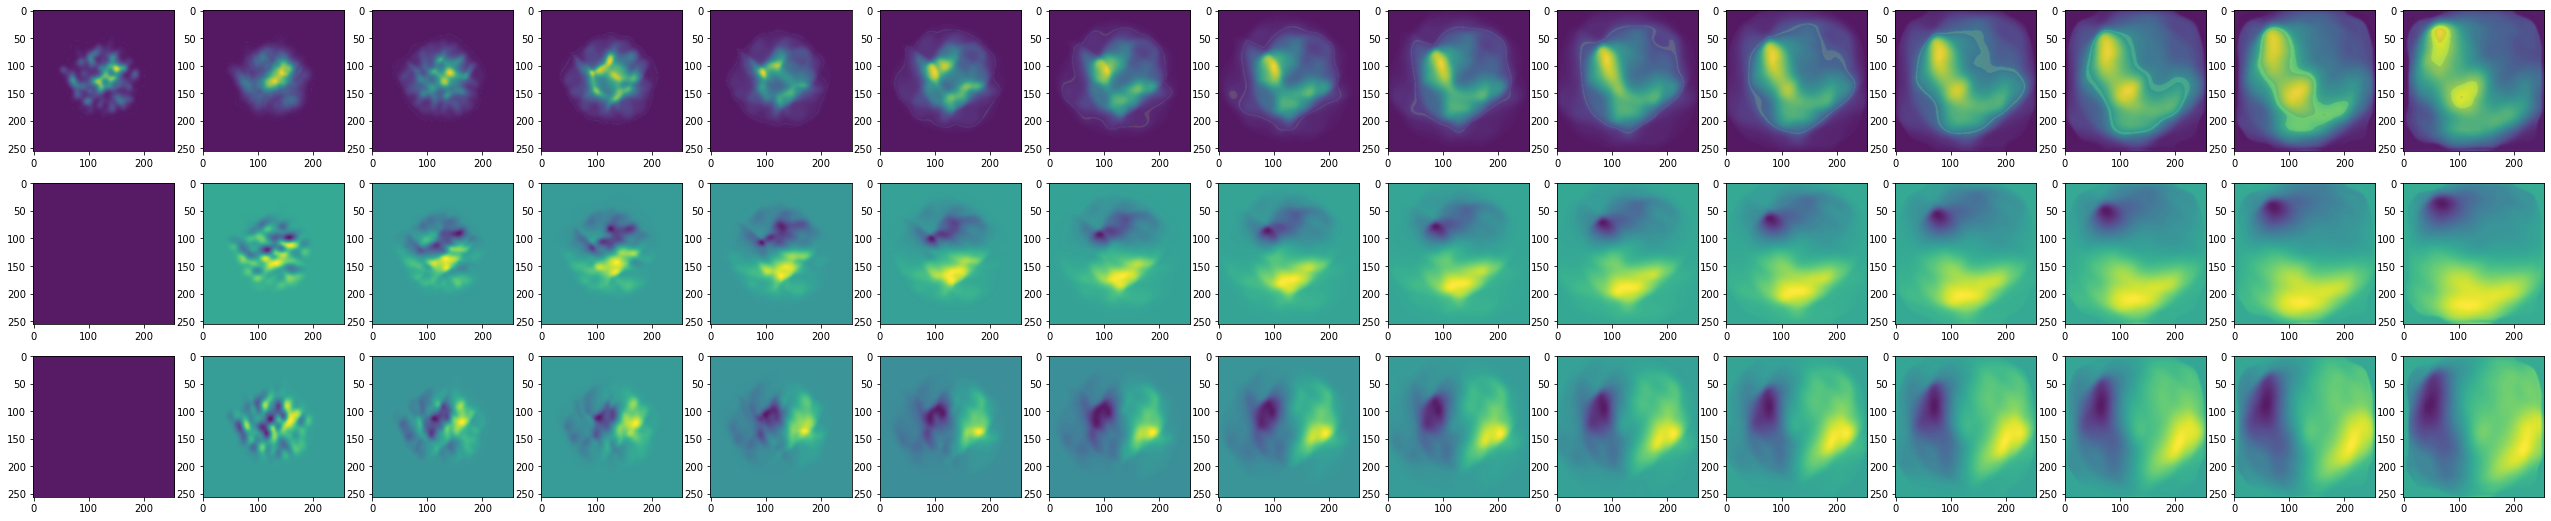

In [44]:
plot_ev(ev)

In [14]:
wrong_evols = []

def loss_pb(x, y, id=-1):
    loss = 0
    if len(x) != len(y):
        wrong_evols.append((id, len(x), len(y)))
    x_l = len(x) // 3
    y_l = len(y) // 3
    for i in range(min(x_l, y_l)):
        loss += unet_loss(x[i], y[i])
        loss += unet_loss(x[i+x_l], y[i+y_l])
        loss += unet_loss(x[i+2 * x_l], y[i+2*y_l])
        
    return loss, min(len(x), len(y))

In [ ]:
from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(998):
    x, y = dataset_pb[i]
    ev = predict_until_freeze_single_model(torch.squeeze(x).numpy())
    er, l = loss_pb(rectify(ev), y, i)
    sum_error[l] += er
    num_evols[l] += 1
    

In [61]:
sum_error

defaultdict(float,
            {24: tensor(14.7986),
             18: tensor(16.6488),
             42: tensor(86.6169),
             27: tensor(15.6920),
             33: tensor(22.9843),
             21: tensor(13.2676),
             30: tensor(15.8921),
             39: tensor(68.2625),
             3: tensor(0.0413),
             15: tensor(15.4186),
             12: tensor(9.4308),
             36: tensor(36.4636),
             9: tensor(3.1599),
             6: tensor(0.9920),
             45: tensor(10.1226)})

In [62]:
num_evols

defaultdict(int,
            {24: 100,
             18: 106,
             42: 58,
             27: 106,
             33: 75,
             21: 95,
             30: 85,
             39: 72,
             3: 1,
             15: 103,
             12: 70,
             36: 66,
             9: 38,
             6: 18,
             45: 5})

Средняя суммарная ошибка за 9 этапов - 0.15

In [65]:
wrong_evols

[(8, 33, 36),
 (11, 27, 30),
 (14, 39, 42),
 (18, 24, 27),
 (21, 15, 18),
 (26, 12, 15),
 (33, 27, 30),
 (43, 42, 45),
 (44, 15, 18),
 (45, 18, 21),
 (53, 24, 27),
 (64, 21, 24),
 (65, 18, 21),
 (69, 27, 30),
 (79, 18, 21),
 (92, 24, 27),
 (108, 15, 18),
 (111, 27, 30),
 (131, 21, 24),
 (132, 48, 45),
 (140, 39, 36),
 (148, 36, 39),
 (153, 27, 30),
 (167, 12, 15),
 (169, 27, 30),
 (185, 24, 27),
 (189, 9, 12),
 (192, 27, 30),
 (220, 33, 36),
 (223, 30, 33),
 (227, 6, 9),
 (247, 33, 36),
 (257, 21, 24),
 (268, 42, 39),
 (276, 15, 18),
 (288, 39, 42),
 (294, 18, 21),
 (304, 15, 18),
 (312, 24, 27),
 (332, 18, 21),
 (334, 9, 12),
 (335, 21, 24),
 (350, 15, 18),
 (355, 36, 39),
 (365, 18, 21),
 (370, 12, 15),
 (378, 30, 33),
 (399, 15, 18),
 (403, 6, 9),
 (411, 9, 12),
 (415, 21, 24),
 (418, 21, 24),
 (422, 21, 24),
 (425, 27, 30),
 (430, 24, 27),
 (434, 15, 18),
 (439, 27, 30),
 (454, 18, 21),
 (455, 21, 24),
 (459, 27, 30),
 (470, 30, 33),
 (476, 18, 21),
 (478, 21, 24),
 (483, 33, 36),


Ограничиваю эволюцию 9 шагами

In [81]:
from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(998):
    x, y = dataset_pb[i]
    ev = predict_until_freeze_single_model(torch.squeeze(x).numpy())
    er, l = loss_pb(rectify(ev), y, i)
    sum_error[l] += er
    num_evols[l] += 1

In [82]:
sum_error

defaultdict(float,
            {24: tensor(14.7986),
             18: tensor(16.6488),
             27: tensor(123.4304),
             21: tensor(13.2676),
             3: tensor(0.0413),
             15: tensor(15.4186),
             12: tensor(9.4308),
             9: tensor(3.1599),
             6: tensor(0.9920)})

In [83]:
num_evols

defaultdict(int,
            {24: 100,
             18: 106,
             27: 467,
             21: 95,
             3: 1,
             15: 103,
             12: 70,
             9: 38,
             6: 18})

## Модель с 3 input

In [71]:
from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(998):
    x, y = dataset_pb[i]
    ev = predict_until_freeze_single_model(torch.squeeze(x).numpy(), mod='ucp_wtt')
    er, l = loss_pb(rectify(ev), y, i)
    sum_error[l] += er
    num_evols[l] += 1
    

In [72]:
sum_error

defaultdict(float,
            {24: tensor(15.9026),
             18: tensor(20.3748),
             27: tensor(172.8120),
             21: tensor(18.1492),
             3: tensor(0.0541),
             15: tensor(19.6629),
             12: tensor(10.2337),
             9: tensor(3.2604),
             6: tensor(1.1056)})

In [73]:
num_evols

defaultdict(int,
            {24: 100,
             18: 103,
             27: 467,
             21: 102,
             3: 1,
             15: 105,
             12: 66,
             9: 36,
             6: 18})

In [78]:
wrong_evols

[(2, 27, 42),
 (6, 27, 33),
 (7, 27, 33),
 (8, 27, 36),
 (10, 27, 30),
 (11, 27, 30),
 (14, 27, 42),
 (17, 27, 30),
 (18, 24, 27),
 (19, 27, 30),
 (21, 15, 18),
 (23, 27, 30),
 (27, 27, 30),
 (28, 27, 39),
 (29, 27, 36),
 (30, 27, 33),
 (32, 27, 39),
 (33, 27, 30),
 (36, 27, 42),
 (43, 27, 45),
 (44, 15, 18),
 (45, 18, 21),
 (46, 27, 39),
 (47, 27, 36),
 (48, 27, 42),
 (53, 24, 27),
 (55, 27, 36),
 (56, 27, 39),
 (59, 27, 39),
 (60, 27, 30),
 (61, 27, 42),
 (64, 21, 24),
 (68, 27, 42),
 (69, 27, 30),
 (72, 27, 39),
 (75, 27, 36),
 (78, 27, 36),
 (83, 27, 36),
 (84, 27, 33),
 (86, 27, 33),
 (88, 27, 36),
 (92, 24, 27),
 (93, 27, 42),
 (97, 27, 39),
 (100, 27, 30),
 (102, 27, 33),
 (103, 27, 30),
 (108, 15, 18),
 (111, 27, 30),
 (116, 27, 42),
 (118, 27, 39),
 (121, 27, 30),
 (126, 27, 30),
 (127, 27, 36),
 (129, 27, 33),
 (130, 27, 42),
 (131, 21, 24),
 (132, 27, 45),
 (133, 27, 42),
 (137, 27, 30),
 (138, 27, 36),
 (139, 27, 36),
 (140, 27, 36),
 (145, 27, 30),
 (147, 27, 36),
 (148, 2

Средняя суммарная ошибка за 9 этапов - 0.37

# Протестируем модель, принимающую 4 входа, а возвращающую 3: ucp_final
ошибка на валидации модели 0.054

### PbPbMinBias

In [118]:
dataset_pb = OxygenDataset('D:/PbPbMinBias')
device = torch.device("cuda:0")

In [165]:
from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(998):
    x, y = dataset_pb[i]
    ev = predict_until_freeze_single_model(torch.squeeze(x).numpy(), mod='ucp_final')
    er, l = loss_pb(rectify(ev), y, i)
    sum_error[l] += er
    num_evols[l] += 1

In [171]:
for ev_len in sum_error.keys():
    er = sum_error[ev_len]
    count = num_evols[ev_len]
    print(f'Evolution length {ev_len // 3}, mean sum error = {er/count}')

Evolution length 8, mean sum error = 0.10894930362701416
Evolution length 6, mean sum error = 0.12190417945384979
Evolution length 9, mean sum error = 0.19957178831100464
Evolution length 7, mean sum error = 0.10550513863563538
Evolution length 1, mean sum error = 0.027192886918783188
Evolution length 5, mean sum error = 0.11466874927282333
Evolution length 4, mean sum error = 0.1031351387500763
Evolution length 3, mean sum error = 0.06340146064758301
Evolution length 2, mean sum error = 0.03887485712766647


In [172]:
wrong_evols

[(2, 27, 42),
 (6, 27, 33),
 (7, 27, 33),
 (8, 27, 36),
 (10, 27, 30),
 (11, 27, 30),
 (14, 27, 42),
 (17, 27, 30),
 (18, 24, 27),
 (19, 27, 30),
 (21, 15, 18),
 (23, 27, 30),
 (26, 12, 15),
 (27, 27, 30),
 (28, 27, 39),
 (29, 27, 36),
 (30, 27, 33),
 (32, 27, 39),
 (33, 27, 30),
 (36, 27, 42),
 (43, 27, 45),
 (44, 15, 18),
 (45, 18, 21),
 (46, 27, 39),
 (47, 27, 36),
 (48, 27, 42),
 (53, 24, 27),
 (55, 27, 36),
 (56, 27, 39),
 (59, 27, 39),
 (60, 27, 30),
 (61, 27, 42),
 (64, 21, 24),
 (65, 18, 21),
 (68, 27, 42),
 (69, 27, 30),
 (72, 27, 39),
 (75, 27, 36),
 (78, 27, 36),
 (79, 18, 21),
 (83, 27, 36),
 (84, 27, 33),
 (86, 27, 33),
 (88, 27, 36),
 (92, 24, 27),
 (93, 27, 42),
 (97, 27, 39),
 (100, 27, 30),
 (102, 27, 33),
 (103, 27, 30),
 (108, 15, 18),
 (111, 27, 30),
 (116, 27, 42),
 (118, 27, 39),
 (121, 27, 30),
 (126, 27, 30),
 (127, 27, 36),
 (129, 27, 33),
 (130, 27, 42),
 (131, 21, 24),
 (132, 27, 45),
 (133, 27, 42),
 (137, 27, 30),
 (138, 27, 36),
 (139, 27, 36),
 (140, 27, 

### XeXeMinBias

In [176]:
dataset_xe = OxygenDataset('D:/XeXeMinBias')
device = torch.device("cuda:0")

In [185]:
from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(996):
    if i == 764:
        continue
    x, y = dataset_xe[i]
    ev = predict_until_freeze_single_model(torch.squeeze(x).numpy(), mod='ucp_final')
    er, l = loss_pb(rectify(ev), y, i)
    sum_error[l] += er
    num_evols[l] += 1

In [186]:
for ev_len in sum_error.keys():
    er = sum_error[ev_len]
    count = num_evols[ev_len]
    print(f'Evolution length {ev_len // 3}, mean sum error = {er/count}')

Evolution length 4, mean sum error = 0.1211467981338501
Evolution length 3, mean sum error = 0.08126486837863922
Evolution length 2, mean sum error = 0.04287290200591087
Evolution length 8, mean sum error = 0.10288593918085098
Evolution length 6, mean sum error = 0.12261556088924408
Evolution length 9, mean sum error = 0.12813757359981537
Evolution length 7, mean sum error = 0.10699499398469925
Evolution length 5, mean sum error = 0.12613274157047272
Evolution length 1, mean sum error = 0.02670002169907093
Evolution length 0, mean sum error = 0.0


In [187]:
num_evols

defaultdict(int,
            {12: 83,
             9: 97,
             6: 121,
             24: 87,
             18: 98,
             27: 270,
             21: 107,
             15: 79,
             3: 43,
             0: 10})

In [188]:
wrong_evols

[(3, 24, 27),
 (9, 27, 33),
 (17, 27, 33),
 (27, 27, 33),
 (28, 12, 15),
 (33, 6, 9),
 (34, 9, 12),
 (40, 0, 3),
 (43, 27, 30),
 (44, 6, 9),
 (45, 27, 30),
 (47, 9, 12),
 (48, 15, 18),
 (51, 24, 27),
 (52, 27, 30),
 (53, 27, 33),
 (54, 27, 30),
 (64, 3, 6),
 (66, 9, 12),
 (70, 27, 30),
 (71, 27, 33),
 (73, 24, 27),
 (76, 27, 36),
 (78, 27, 36),
 (80, 27, 30),
 (81, 27, 30),
 (84, 27, 36),
 (89, 27, 36),
 (91, 27, 33),
 (105, 27, 36),
 (107, 3, 6),
 (109, 27, 30),
 (111, 27, 36),
 (114, 6, 9),
 (119, 15, 18),
 (120, 27, 33),
 (121, 27, 33),
 (126, 3, 6),
 (127, 27, 33),
 (130, 15, 18),
 (135, 6, 9),
 (139, 27, 36),
 (145, 27, 36),
 (150, 9, 6),
 (152, 3, 6),
 (155, 27, 30),
 (156, 27, 36),
 (158, 15, 18),
 (163, 27, 30),
 (164, 6, 9),
 (168, 27, 30),
 (170, 27, 30),
 (171, 27, 36),
 (172, 27, 30),
 (173, 27, 30),
 (174, 27, 36),
 (185, 9, 12),
 (188, 27, 36),
 (191, 27, 33),
 (193, 15, 18),
 (198, 6, 9),
 (199, 27, 33),
 (203, 3, 6),
 (204, 27, 30),
 (209, 18, 21),
 (211, 24, 27),
 (213

### OOMinBias

In [189]:
dataset_oo = OxygenDataset('D:/OOMinBias')
device = torch.device("cuda:0")

In [190]:
from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(len(dataset_oo)):
    x, y = dataset_oo[i]
    ev = predict_until_freeze_single_model(torch.squeeze(x).numpy(), mod='ucp_final')
    er, l = loss_pb(rectify(ev), y, i)
    sum_error[l] += er
    num_evols[l] += 1

In [191]:
for ev_len in sum_error.keys():
    er = sum_error[ev_len]
    count = num_evols[ev_len]
    print(f'Evolution length {ev_len // 3}, mean sum error = {er/count}')

Evolution length 2, mean sum error = 0.03789883852005005
Evolution length 5, mean sum error = 0.12262379378080368
Evolution length 3, mean sum error = 0.07083354890346527
Evolution length 1, mean sum error = 0.027324561029672623
Evolution length 4, mean sum error = 0.09578508883714676
Evolution length 6, mean sum error = 0.16832982003688812
Evolution length 0, mean sum error = 0.0


# ucp_final_retrained.pth
ошибка на валидации 0.050380

### PbPbMinBias

In [12]:
dataset_pb = OxygenDataset('D:/PbPbMinBias')
device = torch.device("cuda:0")

In [15]:
from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(998):
    x, y = dataset_pb[i]
    ev = predict_until_freeze_single_model(torch.squeeze(x).numpy(), mod='ucp_final_retrained')
    er, l = loss_pb(rectify(ev), y, i)
    sum_error[l] += er
    num_evols[l] += 1

In [16]:
for ev_len in sum_error.keys():
    er = sum_error[ev_len]
    count = num_evols[ev_len]
    print(f'Evolution length {ev_len // 3}, mean sum error = {er/count}')

Evolution length 8, mean sum error = 0.10248330980539322
Evolution length 6, mean sum error = 0.1131785437464714
Evolution length 9, mean sum error = 0.1877308040857315
Evolution length 7, mean sum error = 0.0987185463309288
Evolution length 1, mean sum error = 0.024427227675914764
Evolution length 5, mean sum error = 0.10840219259262085
Evolution length 4, mean sum error = 0.0935443863272667
Evolution length 3, mean sum error = 0.058681074529886246
Evolution length 2, mean sum error = 0.035842716693878174


In [18]:
wrong_evols

[(2, 27, 42),
 (6, 27, 33),
 (7, 27, 33),
 (8, 27, 36),
 (10, 27, 30),
 (11, 27, 30),
 (14, 27, 42),
 (17, 27, 30),
 (18, 24, 27),
 (19, 27, 30),
 (21, 15, 18),
 (23, 27, 30),
 (26, 12, 15),
 (27, 27, 30),
 (28, 27, 39),
 (29, 27, 36),
 (30, 27, 33),
 (32, 27, 39),
 (33, 27, 30),
 (36, 27, 42),
 (43, 27, 45),
 (44, 15, 18),
 (45, 18, 21),
 (46, 27, 39),
 (47, 27, 36),
 (48, 27, 42),
 (53, 24, 27),
 (55, 27, 36),
 (56, 27, 39),
 (59, 27, 39),
 (60, 27, 30),
 (61, 27, 42),
 (64, 21, 24),
 (65, 18, 21),
 (68, 27, 42),
 (69, 27, 30),
 (72, 27, 39),
 (75, 27, 36),
 (78, 27, 36),
 (79, 18, 21),
 (83, 27, 36),
 (84, 27, 33),
 (86, 27, 33),
 (88, 27, 36),
 (92, 24, 27),
 (93, 27, 42),
 (97, 27, 39),
 (100, 27, 30),
 (102, 27, 33),
 (103, 27, 30),
 (108, 15, 18),
 (111, 27, 30),
 (116, 27, 42),
 (118, 27, 39),
 (121, 27, 30),
 (126, 27, 30),
 (127, 27, 36),
 (129, 27, 33),
 (130, 27, 42),
 (131, 21, 24),
 (132, 27, 45),
 (133, 27, 42),
 (137, 27, 30),
 (138, 27, 36),
 (139, 27, 36),
 (140, 27, 

### XeXeMinBias

In [21]:
dataset_xe = OxygenDataset('D:/XeXeMinBias')
device = torch.device("cuda:0")

from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(996):
    if i == 764:
        continue
    x, y = dataset_xe[i]
    ev = predict_until_freeze_single_model(torch.squeeze(x).numpy(), mod='ucp_final_retrained')
    er, l = loss_pb(rectify(ev), y, i)
    sum_error[l] += er
    num_evols[l] += 1
    
for ev_len in sum_error.keys():
    er = sum_error[ev_len]
    count = num_evols[ev_len]
    print(f'Evolution length {ev_len // 3}, mean sum error = {er/count}')

Evolution length 4, mean sum error = 0.11007645726203918
Evolution length 3, mean sum error = 0.07422064244747162
Evolution length 2, mean sum error = 0.03980614244937897
Evolution length 8, mean sum error = 0.09671387821435928
Evolution length 6, mean sum error = 0.11172949522733688
Evolution length 9, mean sum error = 0.11995217204093933
Evolution length 7, mean sum error = 0.10158268362283707
Evolution length 5, mean sum error = 0.12019607424736023
Evolution length 1, mean sum error = 0.025137607008218765
Evolution length 0, mean sum error = 0.0


In [22]:
wrong_evols

[(3, 24, 27),
 (9, 27, 33),
 (17, 27, 33),
 (27, 27, 33),
 (28, 12, 15),
 (33, 6, 9),
 (34, 9, 12),
 (40, 0, 3),
 (43, 27, 30),
 (44, 6, 9),
 (45, 27, 30),
 (47, 9, 12),
 (48, 15, 18),
 (52, 27, 30),
 (53, 27, 33),
 (54, 27, 30),
 (64, 3, 6),
 (66, 9, 12),
 (70, 27, 30),
 (71, 27, 33),
 (73, 24, 27),
 (76, 27, 36),
 (78, 27, 36),
 (80, 27, 30),
 (81, 27, 30),
 (84, 27, 36),
 (89, 27, 36),
 (91, 27, 33),
 (105, 27, 36),
 (107, 3, 6),
 (109, 27, 30),
 (111, 27, 36),
 (114, 6, 9),
 (119, 15, 18),
 (120, 27, 33),
 (121, 27, 33),
 (126, 3, 6),
 (127, 27, 33),
 (130, 15, 18),
 (135, 6, 9),
 (139, 27, 36),
 (145, 27, 36),
 (150, 9, 6),
 (152, 3, 6),
 (155, 27, 30),
 (156, 27, 36),
 (158, 15, 18),
 (163, 27, 30),
 (164, 6, 9),
 (168, 27, 30),
 (170, 27, 30),
 (171, 27, 36),
 (172, 27, 30),
 (173, 27, 30),
 (174, 27, 36),
 (185, 9, 12),
 (188, 27, 36),
 (191, 27, 33),
 (193, 15, 18),
 (198, 6, 9),
 (199, 27, 33),
 (203, 3, 6),
 (204, 27, 30),
 (209, 18, 21),
 (211, 24, 27),
 (213, 27, 33),
 (21

### OOMinBias

In [24]:
dataset_oo = OxygenDataset('D:/OOMinBias')
device = torch.device("cuda:0")

from collections import defaultdict

sum_error = defaultdict(float)
num_evols = defaultdict(int) # num_evols[5] - количество эволюций длиной 5
wrong_evols = []
for i in range(len(dataset_oo)):
    if i == 764:
        continue
    x, y = dataset_oo[i]
    ev = predict_until_freeze_single_model(torch.squeeze(x).numpy(), mod='ucp_final_retrained')
    er, l = loss_pb(rectify(ev), y, i)
    sum_error[l] += er
    num_evols[l] += 1
    
for ev_len in sum_error.keys():
    er = sum_error[ev_len]
    count = num_evols[ev_len]
    print(f'Evolution length {ev_len // 3}, mean sum error = {er/count}')

Evolution length 2, mean sum error = 0.03568107262253761
Evolution length 5, mean sum error = 0.11287815868854523
Evolution length 3, mean sum error = 0.06517188251018524
Evolution length 1, mean sum error = 0.026120515540242195
Evolution length 4, mean sum error = 0.08826302736997604
Evolution length 6, mean sum error = 0.15687721967697144
Evolution length 0, mean sum error = 0.0


In [96]:
def loss_pb(x, y, id=-1):
    loss = 0
    if len(x) != len(y):
        wrong_evols.append((id, len(x), len(y)))
    x_l = len(x) // 3
    y_l = len(y) // 3
    for i in range(min(x_l, y_l)):
        loss += unet_loss(x[i], y[i])
        loss += unet_loss(x[i+x_l], y[i+y_l])
        loss += unet_loss(x[i+2 * x_l], y[i+2*y_l])
        
    return loss, min(len(x), len(y))

In [98]:
strange_loss(t[8::9].unsqueeze(0), y[8::9].unsqueeze(0))

tensor(0.0060)

In [99]:
unet_loss(t[0], y[0]) + unet_loss(t[9], y[9]) + unet_loss(t[18], y[18])

tensor(0.0094)

In [106]:
out = torch.cat([t[0].unsqueeze(0), t[9].unsqueeze(0), t[18].unsqueeze(0)])
out = torch.cat([out.unsqueeze(0), out.unsqueeze(0), out.unsqueeze(0), out.unsqueeze(0),
                 out.unsqueeze(0), out.unsqueeze(0), out.unsqueeze(0), out.unsqueeze(0)])
out.shape

torch.Size([8, 3, 256, 256])

In [107]:
tar = torch.cat([y[0].unsqueeze(0), y[9].unsqueeze(0), y[18].unsqueeze(0)])
tar = torch.cat([tar.unsqueeze(0), tar.unsqueeze(0), tar.unsqueeze(0), tar.unsqueeze(0),
                 tar.unsqueeze(0), tar.unsqueeze(0), tar.unsqueeze(0), tar.unsqueeze(0)])
tar.shape

torch.Size([8, 3, 256, 256])

In [108]:
strange_loss(out, tar)

tensor(0.0756)

# Предыдущий подход получился лучше
Посмотрим визуально результат

In [194]:
def plot_xy(x, y):
    l = y.shape[0] //3
    fig = plt.figure(figsize=(3*(l+1), 12))
    fig.add_subplot(4, l+1, 1)
    plt.imshow(x[0])
    fig.add_subplot(4, l+1, 2 + l)
    plt.imshow(np.zeros_like(x[0]))
    fig.add_subplot(4, l+1, 3 + 2*l)
    plt.imshow(np.zeros_like(x[0]))
    for i in range(l):
        fig.add_subplot(4, l+1, i + 2)
        plt.imshow(y[i])
        fig.add_subplot(4, l+1, i + 3 + l)
        plt.imshow(y[i + l])
        fig.add_subplot(4, l+1, i + 4 + 2*l)
        plt.imshow(y[i + 2 * l])
        fig.add_subplot(4, l+1, i + 5 + 3*l)
        plt.imshow(np.abs(y[i]-0.18)<0.01)

In [208]:
x,y = dataset_pb[0]

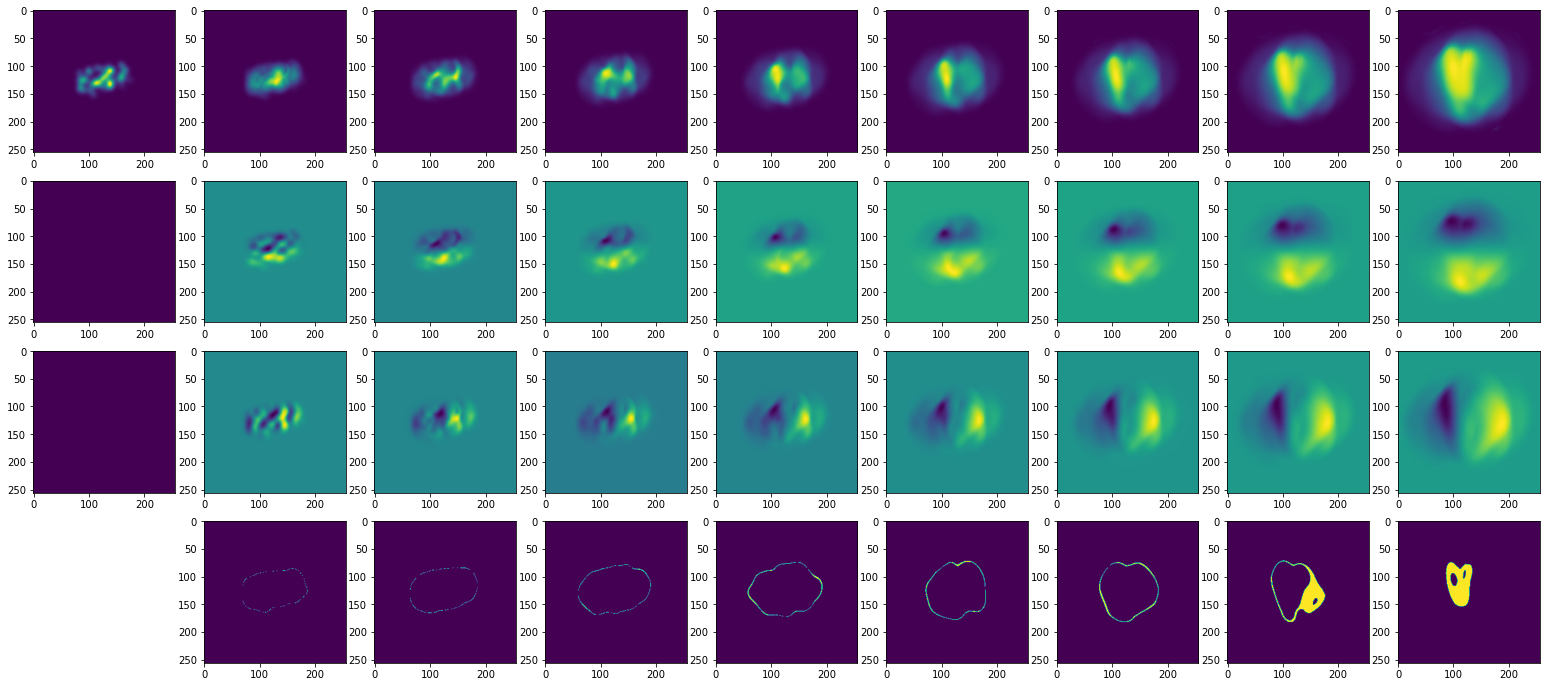

In [209]:
plot_xy(x, y)

(tensor(0.0721), 24)


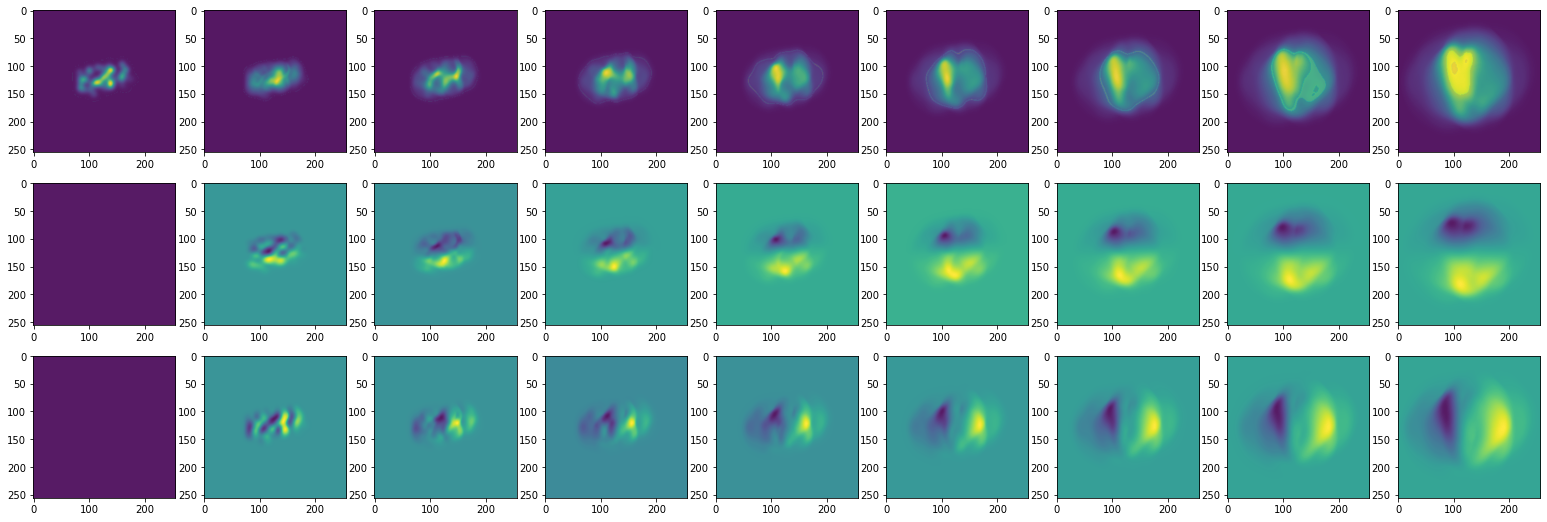

In [210]:
path_to_models='models'
device=torch.device('cpu')
ev = predict_until_freeze(torch.squeeze(x).numpy())
print(loss_pb(rectify(ev), y))
plot_ev(ev)

(tensor(0.0765), 24)


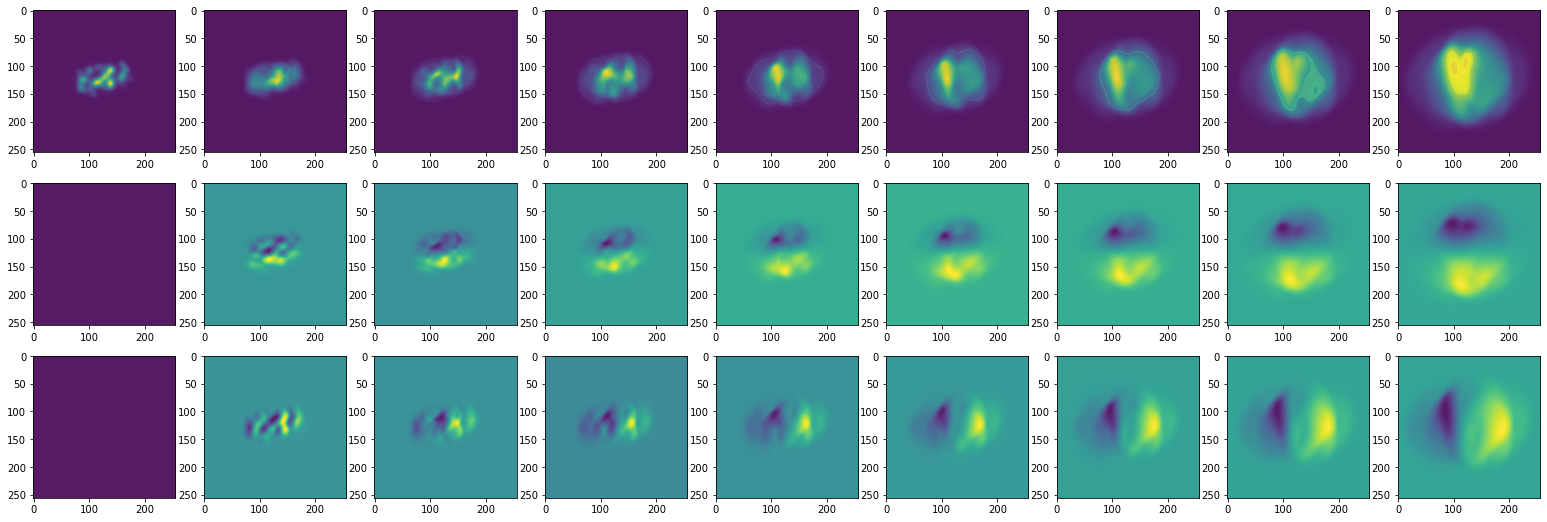

In [211]:
path_to_models = 'C:/Users/Юра/Desktop/CernProject/models'
device=torch.device('cuda:0')
ev = predict_until_freeze_single_model(torch.squeeze(x).numpy(), mod='ucp_final')
print(loss_pb(rectify(ev), y))
plot_ev(ev)